In [19]:
from __future__ import annotations
import torch
import pytomography
from pytomography.metadata import ObjectMeta
from pytomography.metadata.PET import PETSinogramPolygonProjMeta
from pytomography.projectors.PET import PETSinogramSystemMatrix
from pytomography.algorithms import OSEM
from pytomography.io.PET import gate, shared
from pytomography.likelihoods import PoissonLogLikelihood
from pytomography.utils import sss
import os
from pytomography.transforms.shared import GaussianFilter
import matplotlib.pyplot as plt

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

torch.cuda.is_available = lambda: False
print(f"CUDA available: {torch.cuda.is_available()}")
pytomography.device = 'cpu'
print(f"Current device: {pytomography.device}")
torch.cuda.empty_cache()

CUDA available: False
Current device: cpu


In [20]:
# # Visualisation Functions
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider


def visualize_voxel_tensor_3d(voxel_tensor, initial_min_threshold=None, initial_max_threshold=None, 
                               voxel_size_mm=1.0, world_origin=None, min_threshold=None, max_threshold=None):
    """
    Interactive 3D visualization of voxel tensor with dual threshold sliders.

    Args:
        voxel_tensor: (nx, ny, nz) numpy array with voxel counts
        initial_min_threshold: Initial minimum threshold value for the slider (default: min_val)
        initial_max_threshold: Initial maximum threshold value for the slider (default: max_val)
        voxel_size_mm: Size of each voxel in mm (default: 1.0mm)
        world_origin: (x_min, y_min, z_min) world coordinates of voxel (0,0,0) (optional)
        min_threshold: Minimum threshold value for slider range (optional)
        max_threshold: Maximum threshold value for slider range (optional)
    """
    # Extract non-zero voxel coordinates and values
    coords = np.where(voxel_tensor > 0)
    x_coords, y_coords, z_coords = coords
    values = voxel_tensor[coords]

    # Convert voxel indices to world coordinates if world_origin provided
    if world_origin is not None:
        x_min, y_min, z_min = world_origin
        x_coords_world = x_coords * voxel_size_mm + x_min
        y_coords_world = y_coords * voxel_size_mm + y_min
        z_coords_world = z_coords * voxel_size_mm + z_min
        coord_suffix = " (mm)"
    else:
        x_coords_world = x_coords * voxel_size_mm
        y_coords_world = y_coords * voxel_size_mm
        z_coords_world = z_coords * voxel_size_mm
        coord_suffix = f" (×{voxel_size_mm}mm)"

    # Get value range for sliders
    min_val = float(np.min(values))
    max_val = float(np.max(values))

    # Use user-specified min/max threshold range if provided
    slider_min = min_threshold if min_threshold is not None else min_val
    slider_max = max_threshold if max_threshold is not None else max_val

    # Set initial thresholds with defaults
    if initial_min_threshold is None:
        initial_min_threshold = slider_min
    else:
        initial_min_threshold = max(slider_min, min(slider_max, float(initial_min_threshold)))
    
    if initial_max_threshold is None:
        initial_max_threshold = slider_max
    else:
        initial_max_threshold = max(slider_min, min(slider_max, float(initial_max_threshold)))

    # Ensure min <= max
    if initial_min_threshold > initial_max_threshold:
        initial_min_threshold, initial_max_threshold = initial_max_threshold, initial_min_threshold

    print(f"Voxel value range: {min_val} to {max_val}")
    print(f"Total non-zero voxels: {len(values)}")
    print(f"Initial thresholds: {initial_min_threshold} to {initial_max_threshold}")
    print(f"Slider range: {slider_min} to {slider_max}")
    print(f"Voxel resolution: {voxel_size_mm}mm")

    def update_plot(min_thresh, max_thresh):
        # Ensure min <= max
        if min_thresh > max_thresh:
            min_thresh, max_thresh = max_thresh, min_thresh

        # Filter voxels within threshold range
        mask = (values >= min_thresh) & (values <= max_thresh)
        if not np.any(mask):
            print(f"No voxels in threshold range [{min_thresh}, {max_thresh}]")
            return

        filtered_x = x_coords_world[mask]
        filtered_y = y_coords_world[mask]
        filtered_z = z_coords_world[mask]
        filtered_values = values[mask]

        # Create 3D scatter plot
        fig = go.Figure(data=go.Scatter3d(
            x=filtered_x,
            y=filtered_y,
            z=filtered_z,
            mode='markers',
            marker=dict(
                size=1,
                color=filtered_values,
                colorscale='Viridis',
                opacity=0.8,
                colorbar=dict(title="Voxel Count"),
                line=dict(width=0)
            ),
            text=[f'Count: {v}' for v in filtered_values],
            hovertemplate='<b>Voxel (%{x:.1f}, %{y:.1f}, %{z:.1f})</b><br>%{text}<extra></extra>'
        ))

        fig.update_layout(
            title=f'3D Voxel Visualization (Range: [{min_thresh:.6f}, {max_thresh:.6f}], Showing: {len(filtered_values)} voxels)',
            scene=dict(
                xaxis_title=f'X{coord_suffix}',
                yaxis_title=f'Y{coord_suffix}',
                zaxis_title=f'Z{coord_suffix}',
                camera=dict(
                    eye=dict(x=1.5, y=1.5, z=1.5)
                ),
                aspectmode='cube'
            ),
            width=800,
            height=600
        )

        fig.show()

    # Create interactive sliders with linked constraints
    min_threshold_slider = FloatSlider(
        value=initial_min_threshold,
        min=slider_min,
        max=slider_max,
        step=0.01,
        description='Min Threshold:',
        continuous_update=False,
        style={'description_width': 'initial'}
    )

    max_threshold_slider = FloatSlider(
        value=initial_max_threshold,
        min=slider_min,
        max=slider_max,
        step=0.01,
        description='Max Threshold:',
        continuous_update=False,
        style={'description_width': 'initial'}
    )

    # Link sliders to maintain min <= max constraint
    def on_min_change(change):
        if change['new'] > max_threshold_slider.value:
            max_threshold_slider.value = change['new']

    def on_max_change(change):
        if change['new'] < min_threshold_slider.value:
            min_threshold_slider.value = change['new']

    min_threshold_slider.observe(on_min_change, names='value')
    max_threshold_slider.observe(on_max_change, names='value')

    interact(update_plot, 
             min_thresh=min_threshold_slider, 
             max_thresh=max_threshold_slider)


from plotly.subplots import make_subplots
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import interact, IntSlider, FloatSlider

def plot_cross_sections_interactive(numpy_array, vmax=None, title="Orthogonal Cross Sections"):
    """
    Create an interactive 3D cross-section viewer for a 3D numpy array.
    
    Parameters:
    -----------
    numpy_array : np.ndarray
        3D numpy array to visualize (shape: nx, ny, nz)
    vmax : float, optional
        Maximum value for color scale. If None, uses array maximum
    title : str, optional
        Title for the plot
    """
    
    # Ensure input is numpy array
    if not isinstance(numpy_array, np.ndarray):
        raise ValueError("Input must be a numpy array")
    
    if numpy_array.ndim != 3:
        raise ValueError("Input must be a 3D array")
    
    nx, ny, nz = numpy_array.shape
    
    # Set default vmax if not provided
    if vmax is None:
        vmax = numpy_array.max()
    
    def plot_cross_sections_horizontal(x_idx=nx//2, y_idx=ny//2, z_idx=nz//2, 
                                     vmax_slider=vmax, cmap='Magma'):
        fig = make_subplots(rows=1, cols=3, subplot_titles=[
            f'XY plane @ z={z_idx}',
            f'XZ plane @ y={y_idx}',
            f'YZ plane @ x={x_idx}'
        ])

        # XY plane at z=z_idx
        fig.add_trace(go.Heatmap(
            z=numpy_array[:, :, z_idx].T,
            colorscale=cmap,
            zmax=vmax_slider,
            zmin=0,
            showscale=True,
            name=f'XY @ z={z_idx}'
        ), row=1, col=1)

        # XZ plane at y=y_idx
        fig.add_trace(go.Heatmap(
            z=numpy_array[:, y_idx, :].T,
            colorscale=cmap,
            zmax=vmax_slider,
            zmin=0,
            showscale=True,
            name=f'XZ @ y={y_idx}'
        ), row=1, col=2)

        # YZ plane at x=x_idx
        fig.add_trace(go.Heatmap(
            z=numpy_array[x_idx, :, :].T,
            colorscale=cmap,
            zmax=vmax_slider,
            zmin=0,
            showscale=True,
            name=f'YZ @ x={x_idx}'
        ), row=1, col=3)

        fig.update_layout(
            width=1200,
            height=400,
            title_text=title
        )
        fig.show()

    # Create interactive widget
    interact(
        plot_cross_sections_horizontal,
        x_idx=IntSlider(min=0, max=nx-1, step=1, value=nx//2, description='X index'),
        y_idx=IntSlider(min=0, max=ny-1, step=1, value=ny//2, description='Y index'),
        z_idx=IntSlider(min=0, max=nz-1, step=1, value=nz//2, description='Z index'),
        vmax_slider=FloatSlider(min=0, max=numpy_array.max(), step=0.01, value=vmax, description='vmax'),
        cmap=['Magma','Greys', 'Viridis', 'Cividis', 'Plasma']
    )


In [21]:
# LOAD LOR DATA
# Initial Loading, Filtering, and Coordinate Range Calculation
import numpy as np

# Load coordinates
coordinates = np.load(fr"C:\Users\h\Desktop\PetStuff\Image_Processing\ground_truth.npy")

# Confirm shape should be (pairs, coords=6), coords are (x1, y1, z1, x2, y2, z2)
print(f"\nData Shape (pairs, coords) : {coordinates.shape}\n")  

# Remove pairs where any coordinate value is exactly 0
filtered_coordinates = coordinates[~np.any(coordinates == 0, axis=1)]
print(f"Filtered shape: {filtered_coordinates.shape}\n")
filtered_coordinates = torch.from_numpy(filtered_coordinates).float()

# Extract all x, y, z pairs - Coordinates are in the order (x1, y1, z1, x2, y2, z2)
all_xyz = filtered_coordinates.reshape(-1, 3) # Reshape to (pairs, 3) for (x, y, z)
x_vals, y_vals, z_vals = all_xyz[:, 0], all_xyz[:, 1], all_xyz[:, 2]
print(f"x range: min={x_vals.min()}, max={x_vals.max()}")
print(f"y range: min={y_vals.min()}, max={y_vals.max()}")
print(f"z range: min={z_vals.min()}, max={z_vals.max()}")


Data Shape (pairs, coords) : (62660, 6)

Filtered shape: (6591, 6)

x range: min=-278.1294250488281, max=278.1666564941406
y range: min=-278.4194641113281, max=277.8843688964844
z range: min=-147.99453735351562, max=147.9492950439453


In [22]:
voxel_size = 4.0

def binary_rasterize_lors_3d_dda(pairs_coords, voxel_size_mm=1.0):
    """
    Rasterize lines of response into 3D voxel space using exact 3D DDA traversal.
    
    Args:
        pairs_coords: (N, 6) array where each row is [x1,y1,z1,x2,y2,z2]
        voxel_size_mm: Size of each voxel in mm (default: 1.0mm)
    
    Returns:
        voxel_tensor: (nx, ny, nz) array with line traversal counts
    """
    # World coordinate ranges (mm)
    all_xyz = pairs_coords.reshape(-1, 3) # Reshape to (pairs, 3) for (x, y, z)
    x_vals, y_vals, z_vals = all_xyz[:, 0], all_xyz[:, 1], all_xyz[:, 2]

    x_min = x_vals.min()
    x_max = x_vals.max()
    y_min = y_vals.min()
    y_max = y_vals.max()
    z_min = z_vals.min()
    z_max = z_vals.max()

    # Round the min and max values to voxel boundaries
    x_min = np.floor(x_min / voxel_size_mm) * voxel_size_mm
    x_max = np.ceil(x_max / voxel_size_mm) * voxel_size_mm
    y_min = np.floor(y_min / voxel_size_mm) * voxel_size_mm
    y_max = np.ceil(y_max / voxel_size_mm) * voxel_size_mm
    z_min = np.floor(z_min / voxel_size_mm) * voxel_size_mm
    z_max = np.ceil(z_max / voxel_size_mm) * voxel_size_mm

    # Calculate voxel tensor shape based on resolution
    nx = int((x_max - x_min) / voxel_size_mm)
    ny = int((y_max - y_min) / voxel_size_mm)
    nz = int((z_max - z_min) / voxel_size_mm)
    
    voxel_shape = (nx, ny, nz)
    print(f"Voxel size: {voxel_size_mm}mm")
    print(f"Voxel shape: {voxel_shape} (nx, ny, nz)")
    
    voxel_tensor = np.zeros(voxel_shape, dtype=np.int32)
    
    # Coordinate transformation: world -> voxel indices
    def world_to_voxel(coords):
        x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]
        vx = (x - x_min) / voxel_size_mm
        vy = (y - y_min) / voxel_size_mm
        vz = (z - z_min) / voxel_size_mm
        return np.column_stack([vx, vy, vz])
    
    def dda_3d(p1, p2):
        """3D DDA algorithm - returns list of (x,y,z) voxel indices along line"""
        x1, y1, z1 = p1
        x2, y2, z2 = p2
        
        # Direction and step sizes
        dx = x2 - x1
        dy = y2 - y1
        dz = z2 - z1
        
        # Number of steps is maximum of absolute differences
        steps = int(max(abs(dx), abs(dy), abs(dz)))
        if steps == 0:
            return [(int(round(x1)), int(round(y1)), int(round(z1)))]
        
        # Step increments
        x_inc = dx / steps
        y_inc = dy / steps
        z_inc = dz / steps
        
        voxels = []
        x, y, z = x1, y1, z1
        
        for _ in range(steps + 1):
            vx, vy, vz = int(round(x)), int(round(y)), int(round(z))
            
            # Check bounds
            if 0 <= vx < nx and 0 <= vy < ny and 0 <= vz < nz:
                voxels.append((vx, vy, vz))
            
            x += x_inc
            y += y_inc
            z += z_inc
        
        return voxels
    
    # Transform all coordinates to voxel space
    points1 = world_to_voxel(pairs_coords[:, :3])  # First points
    points2 = world_to_voxel(pairs_coords[:, 3:])  # Second points
    
    # Process each LOR
    for i in range(len(pairs_coords)):
        p1 = points1[i]
        p2 = points2[i]
        
        # Get voxels along this line
        voxels = dda_3d(p1, p2)
        
        # Increment voxel counts
        for vx, vy, vz in voxels:
            voxel_tensor[vx, vy, vz] += 1
    
    return voxel_tensor

voxel_tensor = binary_rasterize_lors_3d_dda(filtered_coordinates, voxel_size_mm=voxel_size)
print(f"Voxel tensor shape: {voxel_tensor.shape}")

# Specify object space for reconstruction
# voxel_space = voxel_tensor.shape # voxels
voxel_space = voxel_tensor.shape # voxels

Voxel size: 4.0mm
Voxel shape: (140, 140, 74) (nx, ny, nz)
Voxel tensor shape: (140, 140, 74)


In [23]:
print(f"x range: min={x_vals.min()}, max={x_vals.max()}")
print(f"y range: min={y_vals.min()}, max={y_vals.max()}")
print(f"z range: min={z_vals.min()}, max={z_vals.max()}")

x range: min=-278.1294250488281, max=278.1666564941406
y range: min=-278.4194641113281, max=277.8843688964844
z range: min=-147.99453735351562, max=147.9492950439453


In [24]:
info = {'min_rsector_difference': 0,
 'crystal_length': 20.0,
 'radius': 337.0,
 'crystalTransNr': 8,
 'crystalTransSpacing': 4.0,
 'crystalAxialNr': 8,
 'crystalAxialSpacing': 4.0,
 'submoduleAxialNr': 1,
 'submoduleAxialSpacing': 0,
 'submoduleTransNr': 1,
 'submoduleTransSpacing': 0,
 'moduleTransNr': 1,
 'moduleTransSpacing': 0.0,
 'moduleAxialNr': 8,
 'moduleAxialSpacing': 32.25,
 'rsectorTransNr': 56,
 'rsectorAxialNr': 1,
 'NrCrystalsPerRing': 448,
 'NrRings': 64,
 'firstCrystalAxis': 1}


from scipy.spatial import cKDTree

def map_lor_endpoints_to_detectors(coordinates, scanner_info):
    """
    Maps LOR endpoints to detector IDs based on PET scanner geometry.
    
    Parameters:
    -----------
    coordinates : numpy.ndarray
        Shape (n_lors, 6) containing [x1, y1, z1, x2, y2, z2] for each LOR
    scanner_info : dict
        Dictionary containing scanner geometry parameters
        
    Returns:
    --------
    numpy.ndarray
        Shape (n_lors, 2) containing detector ID pairs for each LOR
    """
    
    # Extract scanner parameters
    radius = scanner_info['radius']
    crystals_per_ring = scanner_info['NrCrystalsPerRing']
    n_rings = scanner_info['NrRings']
    crystal_axial_spacing = scanner_info['crystalAxialSpacing']
    module_axial_spacing = scanner_info['moduleAxialSpacing']
    module_axial_nr = scanner_info['moduleAxialNr']
    crystals_axial_per_module = scanner_info['crystalAxialNr']
    
    # Calculate total axial extent
    # Each ring is spaced by crystal spacing within modules, plus module spacing between modules
    crystals_per_module_axial = crystals_axial_per_module
    modules_span = (module_axial_nr - 1) * module_axial_spacing
    crystals_within_modules_span = (crystals_per_module_axial - 1) * crystal_axial_spacing * module_axial_nr
    total_axial_extent = modules_span + crystals_within_modules_span
    
    # Generate detector positions
    detector_positions = []
    detector_ids = []
    
    for ring in range(n_rings):
        # Calculate z position for this ring
        if n_rings == 1:
            z_pos = 0.0
        else:
            # Distribute rings evenly across the total axial extent
            z_pos = -total_axial_extent/2 + ring * (total_axial_extent / (n_rings - 1))
        
        for crystal in range(crystals_per_ring):
            # Calculate angular position
            angle = 2 * np.pi * crystal / crystals_per_ring
            
            # Convert to Cartesian coordinates
            x_pos = radius * np.cos(angle)
            y_pos = radius * np.sin(angle)
            
            detector_positions.append([x_pos, y_pos, z_pos])
            
            # Calculate detector ID following PET convention
            detector_id = ring * crystals_per_ring + crystal
            detector_ids.append(detector_id)
    
    detector_positions = np.array(detector_positions)
    detector_ids = np.array(detector_ids)
    
    print(f"Generated {len(detector_positions)} detectors")
    print(f"Detector position range:")
    print(f"  X: {detector_positions[:, 0].min():.1f} to {detector_positions[:, 0].max():.1f} mm")
    print(f"  Y: {detector_positions[:, 1].min():.1f} to {detector_positions[:, 1].max():.1f} mm") 
    print(f"  Z: {detector_positions[:, 2].min():.1f} to {detector_positions[:, 2].max():.1f} mm")
    
    # Build KDTree for efficient nearest neighbor search
    kdtree = cKDTree(detector_positions)
    
    # Extract all LOR endpoints
    n_lors = coordinates.shape[0]
    all_endpoints = coordinates.reshape(-1, 3)  # Shape: (n_lors * 2, 3)
    
    # Find nearest detector for each endpoint
    distances, nearest_indices = kdtree.query(all_endpoints)
    
    # Convert spatial indices back to detector IDs
    nearest_detector_ids = detector_ids[nearest_indices]
    
    # Reshape to get detector ID pairs for each LOR
    detector_pairs = nearest_detector_ids.reshape(n_lors, 2)
    
    # Print some statistics
    print(f"\nMapping Statistics:")
    print(f"Average distance to nearest detector: {distances.mean():.2f} mm")
    print(f"Max distance to nearest detector: {distances.max():.2f} mm")
    print(f"Detector ID range: {detector_ids.min()} to {detector_ids.max()}")
    
    # Show a few examples
    print(f"\nFirst 5 LOR detector mappings:")
    for i in range(min(5, n_lors)):
        x1, y1, z1, x2, y2, z2 = coordinates[i]
        det1, det2 = detector_pairs[i]
        print(f"  LOR {i}: ({x1:.1f}, {y1:.1f}, {z1:.1f}) -> Det {det1}, "
              f"({x2:.1f}, {y2:.1f}, {z2:.1f}) -> Det {det2}")
    
    return detector_pairs

detector_ids = map_lor_endpoints_to_detectors(filtered_coordinates.numpy(), info)
detector_ids = torch.tensor(detector_ids)
print(f"\nDetector ids shape: {detector_ids.shape}") # Should be (n_lors, 2)

Generated 28672 detectors
Detector position range:
  X: -337.0 to 337.0 mm
  Y: -337.0 to 337.0 mm
  Z: -224.9 to 224.9 mm

Mapping Statistics:
Average distance to nearest detector: 74.13 mm
Max distance to nearest detector: 101.84 mm
Detector ID range: 0 to 28671

First 5 LOR detector mappings:
  LOR 0: (-134.0, -214.8, -105.7) -> Det 7912, (-123.0, -237.5, 114.4) -> Det 21806
  LOR 1: (-95.5, 219.4, -101.3) -> Det 7757, (-207.2, -150.3, 103.9) -> Det 20877
  LOR 2: (133.6, -194.4, -114.3) -> Det 7099, (14.6, -238.8, 132.0) -> Det 22740
  LOR 3: (245.5, -12.9, 137.4) -> Det 23292, (65.6, -228.2, 114.3) -> Det 21860
  LOR 4: (236.0, -132.1, -84.1) -> Det 9372, (253.7, -93.5, -79.3) -> Det 9383

Detector ids shape: torch.Size([6591, 2])


In [25]:
# FAKE DATA GENERATION FOR TESTING
# Create a 1000x2 tensor with random integers, ensuring pairs are never equal
detector_ids = torch.full((1000, 2), 0, dtype=torch.long)
detector_ids[:, 0] = 3
detector_ids[:, 1] = 6
detector_ids = torch.randint(low=0, high=64*8, size=(1000, 2))
print(detector_ids.shape)

torch.Size([1000, 2])


In [26]:
# atten_map = gate.get_aligned_attenuation_map(os.path.join(path, 'gate_simulation/simple_phantom/umap_mMR_brainSimplePhantom.hv'), object_meta).to(pytomography.device)

# Get or Create attenuation map 
ones_atten_map = torch.ones(voxel_space)
zeros_atten_map = torch.zeros(voxel_space)

# create a half-rectangular attenuation map
half_rect_atten_map = torch.zeros(voxel_space)
mid_x = voxel_space[0] // 2
half_rect_atten_map[:mid_x, :, :] = torch.linspace(0, 0.1, mid_x).view(-1, 1, 1)

# Create a gradient attenuation map
coords = torch.stack(torch.meshgrid(
    torch.arange(voxel_space[0]),
    torch.arange(voxel_space[1]),
    torch.arange(voxel_space[2]),
    indexing='ij'
), dim=-1).float()
gradient_atten_map = coords.mean(dim=-1)
gradient_atten_map = gradient_atten_map / gradient_atten_map.max()

# Create a cylindrical attenuation map with radial gradient
radius_mm = 278  # cylinder radius in mm
height = voxel_space[2] * voxel_size  # cylinder height in mm
center_x = voxel_space[0] // 2
center_y = voxel_space[1] // 2
center_z = voxel_space[2] // 2
radius_vox = radius_mm / voxel_size

# Generate grid of voxel indices
x = torch.arange(voxel_space[0]).float()
y = torch.arange(voxel_space[1]).float()
z = torch.arange(voxel_space[2]).float()
xx, yy, zz = torch.meshgrid(x, y, z, indexing='ij')

# Compute distance from central axis for each voxel
dist_from_axis = torch.sqrt((xx - center_x)**2 + (yy - center_y)**2)

# Create gradient cylinder attenuation map
gradient_cylindrical_atten_map = torch.ones(voxel_space)
normalized_dist = dist_from_axis / radius_vox  # Normalize distances to [0,1]

# Create radial gradient: high attenuation (1.0) at center, decreasing outward
gradient_cylindrical_atten_map = 1.0 - normalized_dist.clone()  # Invert the gradient
gradient_cylindrical_atten_map[gradient_cylindrical_atten_map < 0] = 0  # Clip negative values
gradient_cylindrical_atten_map[dist_from_axis > radius_vox] = 0  # Set outside cylinder to 0
gradient_cylindrical_atten_map /= 100

# Also create a solid cylinder for comparison
cylindrical_atten_map = torch.zeros(voxel_space)
cylindrical_atten_map[dist_from_axis <= radius_vox] = 0.01 # 0.14  cm⁻¹ is the attenuation for dense bone apparently


# Create a spherical attenuation map centered at origin
def create_spherical_atten_map(voxel_space, voxel_size, radius_mm=None, atten_value=0.1):
    """
    Create a spherical attenuation map centered at the midpoint of voxel space.
    
    Args:
        voxel_space: tuple (x, y, z) dimensions of the voxel grid
        voxel_size: size of each voxel in mm
        radius_mm: sphere radius in mm. If None, defaults to 1/4 of smallest axis
        atten_value: attenuation value inside the sphere (default 0.1)
    
    Returns:
        torch.Tensor: spherical attenuation map with shape voxel_space
    """
    # Calculate default radius if not specified
    if radius_mm is None:
        min_axis_mm = min(voxel_space) * voxel_size
        radius_mm = min_axis_mm / 4
    
    # Convert radius to voxel units
    radius_vox = radius_mm / voxel_size
    
    # Calculate center coordinates
    center_x = voxel_space[0] // 2
    center_y = voxel_space[1] // 2
    center_z = voxel_space[2] // 2
    
    # Generate grid of voxel indices
    x = torch.arange(voxel_space[0]).float()
    y = torch.arange(voxel_space[1]).float()
    z = torch.arange(voxel_space[2]).float()
    xx, yy, zz = torch.meshgrid(x, y, z, indexing='ij')
    
    # Compute distance from center for each voxel
    dist_from_center = torch.sqrt((xx - center_x)**2 + (yy - center_y)**2 + (zz - center_z)**2)
    
    # Create spherical attenuation map
    spherical_atten_map = torch.zeros(voxel_space)
    spherical_atten_map[dist_from_center <= radius_vox] = atten_value
    
    return spherical_atten_map

# Usage example with your existing variables:
spherical_atten_map = create_spherical_atten_map(voxel_space, voxel_size, atten_value=0.01)

# Or with custom radius:
# spherical_atten_map = create_spherical_atten_map(voxel_space, voxel_size, radius_mm=100, atten_value=0.1)

In [27]:

sinogram = gate.listmode_to_sinogram(detector_ids, info)

normalization_weights = None
# Get information dictionary about the scanner
# info = gate.get_detector_info(path = macro_path,
#     mean_interaction_depth=9, min_rsector_difference=0)

normalization_sinogram = gate.get_norm_sinogram_from_listmode_data(normalization_weights, info)

# Specify object space for reconstruction
object_meta = ObjectMeta(
    dr=(2,2,2), #mm
    shape=(128,128,96) #voxels
)
# # Create object metadata (same as before)
# object_meta = ObjectMeta(
#     shape=voxel_tensor.shape,  # Your image dimensions
#     dr=(voxel_size, voxel_size, voxel_size),    # Voxel sizes in mm
# )

proj_meta = PETSinogramPolygonProjMeta(info)

# atten_map = half_rect_atten_map 
# atten_map = gradient_atten_map 
# atten_map = cylindrical_atten_map
atten_map = gradient_cylindrical_atten_map
# atten_map = ones_atten_map
# atten_map = zeros_atten_map
# atten_map = spherical_atten_map
# atten_map = None
atten_map.to(pytomography.device)

# Create PSF transform
psf_transform = GaussianFilter(3.) # 3mm gaussian blurring

system_matrix = PETSinogramSystemMatrix(
       object_meta,
       proj_meta,
       obj2obj_transforms = [psf_transform],
       sinogram_sensitivity = normalization_sinogram,
       N_splits=10, # Split FP/BP into 10 loops to save memory
       attenuation_map=atten_map,
       device='cpu' # projections are output on the CPU, but internal computation is on GPU
)

likelihood = PoissonLogLikelihood(
    system_matrix,
    sinogram,
)

# Initialize reconstruction algorithm
recon_algorithm = OSEM(likelihood)

# Reconstruct
recon_primaryonly = recon_algorithm(n_iters=2, n_subsets=24)
initial_image = torch.ones(object_meta.shape)

# Forward projection
projections = system_matrix.forward(initial_image)
# Back projection
back_projected = system_matrix.backward(projections)

print(f"Input image shape: {initial_image.shape}")
print(f"Projections shape: {projections.shape}")
print(f"Back projected shape: {back_projected.shape}")

Input image shape: torch.Size([128, 128, 96])
Projections shape: torch.Size([224, 449, 4096])
Back projected shape: torch.Size([128, 128, 96])


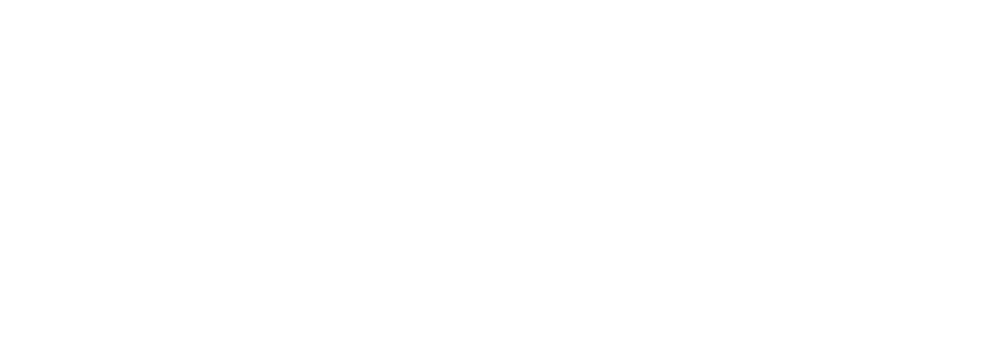

In [28]:
vmax = 0.45
cmap='Greys'
fig, ax = plt.subplots(1,3,figsize=(10,4), gridspec_kw={'wspace': 0.0})
plt.subplot(131)
plt.imshow(recon_primaryonly[50,16:-16].cpu().T, cmap=cmap, interpolation='gaussian', vmax=vmax, origin='lower')
plt.axis('off')
plt.subplot(132)
plt.imshow(recon_primaryonly[16:-16,64].cpu().T, cmap=cmap, interpolation='gaussian', vmax=vmax, origin='lower')
plt.axis('off')
plt.subplot(133)
plt.imshow(recon_primaryonly[:,:,48].cpu().T, cmap=cmap, interpolation='gaussian', vmax=vmax, origin='lower')
plt.axis('off')
fig.tight_layout()
plt.show()

In [29]:
plot_cross_sections_interactive(recon_primaryonly.cpu().numpy())

interactive(children=(IntSlider(value=64, description='X index', max=127), IntSlider(value=64, description='Y …